# Meta-Analytic Functional Decoding

In [1]:
# First, import the necessary modules and functions
import os

import matplotlib.pyplot as plt
from myst_nb import glue
from nilearn import plotting

DATA_DIR = os.path.abspath("../data")
FIG_DIR = os.path.abspath("../images")

/home/data/nbc/misc-projects/Salo_NiMARE/conda_env/lib/python3.7/site-packages/nilearn/datasets/__init__.py:90: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


In [2]:
import nimare
from nimare import meta

dset_file = os.path.join(DATA_DIR, "neurosynth_dataset_first500_with_mkda_ma.pkl.gz")
kern = meta.kernel.MKDAKernel(memory_limit=None)
target_folder = os.path.join(DATA_DIR, "neurosynth_dataset_maps")
if not os.path.isfile(dset_file):
    neurosynth_dset_first500 = nimare.dataset.Dataset.load(
        os.path.join(DATA_DIR, "neurosynth_dataset_first500.pkl.gz")
    )
    os.makedirs(target_folder, exist_ok=True)
    neurosynth_dset_first500.update_path(target_folder)
    neurosynth_dset_first500 = kern.transform(neurosynth_dset_first500, return_type="dataset")
    neurosynth_dset_first500.save(dset_file)
else:
    neurosynth_dset_first500 = nimare.dataset.Dataset.load(dset_file)
    neurosynth_dset_first500.update_path(target_folder)

# Collect features for decoding
# We use any features that appear in >10% of studies and <90%.
id_cols = ["id", "study_id", "contrast_id"]
frequency_threshold = 0.001
cols = neurosynth_dset_first500.annotations.columns
cols = [c for c in cols if c not in id_cols]
df = neurosynth_dset_first500.annotations.copy()[cols]
n_studies = df.shape[0]
feature_counts = (df >= frequency_threshold).sum(axis=0)
target_features = feature_counts.between(n_studies * 0.1, n_studies * 0.9)
target_features = target_features[target_features]
target_features = target_features.index.values
print(f"{len(target_features)} features selected.", flush=True)

continuous_map = os.path.join(DATA_DIR, "map_to_decode.nii.gz")
amygdala_roi = os.path.join(DATA_DIR, "amygdala_roi.nii.gz")
amygdala_ids = neurosynth_dset_first500.get_studies_by_mask(amygdala_roi)

INFO:nimare.dataset:Overwriting images column affine-34d2ff913320e14f04a4746cfa875fcd_memory_limit-None_r-10.0_value-1_MKDAKernel


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


95 features selected.


Functional decoding performed with meta-analytic data, refers to methods which attempt to predict mental states from neuroimaging data using a large-scale meta-analytic database {cite:p}`Smith2009-wk`.
Such analyses may also be referred to as “informal reverse inference” {cite:p}`Poldrack2011-zp`, “functional characterization analysis” {cite:p}`Bzdok2013-gc,Cieslik2013-kz,Rottschy2013-cd`, “open-ended decoding” {cite:p}`Rubin2017-rd`, or simply “functional decoding” {cite:p}`Amft2015-kw,Bzdok2013-jv,Nickl-Jockschat2015-rg`.
While the terminology is far from standardized, we will refer to this method as **meta-analytic functional decoding** in order to distinguish it from alternative methods like multivariate decoding and model-based decoding {cite:p}`Poldrack2011-zp`.
Meta-analytic functional decoding is often used in conjunction with MACM, meta-analytic clustering, meta-analytic parcellation, and meta-ICA, in order to characterize resulting brain regions, clusters, or components.
Meta-analytic functional decoding models have also been extended for the purpose of **meta-analytic functional encoding**, wherein text is used to generate statistical images {cite:p}`Dockes2018-ug,Nunes2018-du,Rubin2017-rd`.

Four common approaches are correlation-based decoding, dot-product decoding, weight-sum decoding, and chi-square decoding.
We will first discuss continuous decoding methods (i.e., correlation and dot-product), followed by discrete decoding methods (weight-sum and chi-square).

## Decoding continuous inputs

When decoding unthresholded statistical maps (such as {numref}`figure_map_to_decode`), the most common approaches are to simply correlate the input map with maps from the database, or to compute the dot product between the two maps.
In Neurosynth, meta-analyses are performed for each label (i.e., term or topic) in the database and then the input image is correlated with the resulting unthresholded statistical map from each meta-analysis.
Performing statistical inference on the resulting correlations is not straightforward, however, as voxels display strong spatial correlations, and the true degrees of freedom are consequently unknown (and likely far smaller than the nominal number of voxels).
In order to interpret the results of this decoding approach, users typically select some arbitrary number of top correlation coefficients ahead of time, and use the associated labels to describe the input map.
However, such results should be interpreted with great caution.

/home/data/nbc/misc-projects/Salo_NiMARE/conda_env/lib/python3.7/site-packages/nilearn/_utils/niimg.py:62: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  "Non-finite values detected. "


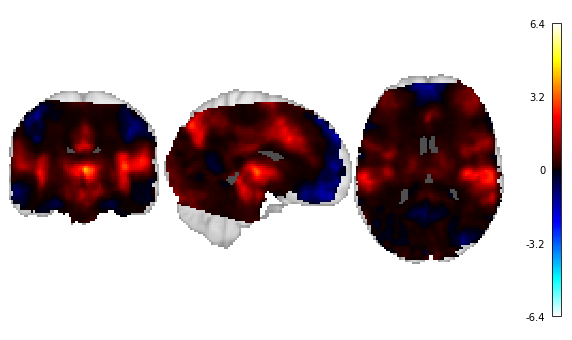

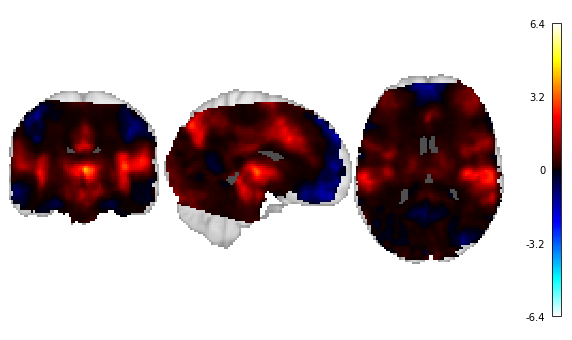

In [3]:
fig, ax = plt.subplots(figsize=(10, 6))
plotting.plot_stat_map(continuous_map, axes=ax, figure=fig, annotate=False, draw_cross=False)
glue("figure_map_to_decode", fig, display=False)

```{glue:figure} figure_map_to_decode
:name: figure_map_to_decode
:align: center

The unthresholded statistical map that will be used for continuous decoding.
```

This approach can also be applied to an image-based database like NeuroVault, either by correlating input data with meta-analyzed statistical maps, or by deriving distributions of correlation coefficients by grouping statistical maps in the database according to label.
Using these distributions, it is possible to statistically compare labels in order to assess label significance.
NiMARE includes methods for both correlation-based decoding and correlation distribution-based decoding, although the correlation-based decoding is better established and should be preferred over the correlation distribution-based decoding.
As such, we will only show the {py:class}`nimare.decode.continuous.CorrelationDecoder` here.

```{warning}
{py:class}`nimare.decode.continuous.CorrelationDecoder` currently runs _very_ slowly.
We strongly recommend running it on a subset of labels within the `Dataset`.
```

In [4]:
from nimare import decode, meta

corr_decoder = decode.continuous.CorrelationDecoder(
    frequency_threshold=0.001,
    meta_estimator=meta.MKDAChi2(kernel_transformer=kern, memory_limit=None),
    target_image="z_desc-specificity",
    features=target_features,
    memory_limit=None,
)
corr_decoder.fit(neurosynth_dset_first500)
corr_df = corr_decoder.transform(continuous_map)

INFO:nimare.decode.continuous:Decoding terms_abstract_tfidf__activations (0/95): 81/500 studies


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


/home/data/nbc/misc-projects/Salo_NiMARE/conda_env/lib/python3.7/site-packages/nimare/meta/cbma/mkda.py:259: RuntimeWarning: invalid value encountered in true_divide
  pFgA = pAgF * pF / pA
/home/data/nbc/misc-projects/Salo_NiMARE/conda_env/lib/python3.7/site-packages/nimare/meta/cbma/mkda.py:263: RuntimeWarning: invalid value encountered in true_divide
  pFgA_prior = pAgF * self.prior / pAgF_prior


INFO:nimare.decode.continuous:Decoding terms_abstract_tfidf__anterior (1/95): 156/500 studies


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.decode.continuous:Decoding terms_abstract_tfidf__anterior cingulate (2/95): 59/500 studies


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.decode.continuous:Decoding terms_abstract_tfidf__attention (3/95): 63/500 studies


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.decode.continuous:Decoding terms_abstract_tfidf__auditory (4/95): 61/500 studies


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.decode.continuous:Decoding terms_abstract_tfidf__cerebral (5/95): 62/500 studies


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.decode.continuous:Decoding terms_abstract_tfidf__cingulate (6/95): 107/500 studies


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.decode.continuous:Decoding terms_abstract_tfidf__cognitive (7/95): 82/500 studies


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.decode.continuous:Decoding terms_abstract_tfidf__common (8/95): 51/500 studies


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.decode.continuous:Decoding terms_abstract_tfidf__condition (9/95): 50/500 studies


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.decode.continuous:Decoding terms_abstract_tfidf__conditions (10/95): 65/500 studies


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.decode.continuous:Decoding terms_abstract_tfidf__contrast (11/95): 74/500 studies


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.decode.continuous:Decoding terms_abstract_tfidf__control (12/95): 117/500 studies


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.decode.continuous:Decoding terms_abstract_tfidf__cortical (13/95): 126/500 studies


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.decode.continuous:Decoding terms_abstract_tfidf__cortices (14/95): 77/500 studies


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.decode.continuous:Decoding terms_abstract_tfidf__demonstrated (15/95): 60/500 studies


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.decode.continuous:Decoding terms_abstract_tfidf__did (16/95): 61/500 studies


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.decode.continuous:Decoding terms_abstract_tfidf__dorsal (17/95): 63/500 studies


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.decode.continuous:Decoding terms_abstract_tfidf__dorsolateral (18/95): 52/500 studies


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.decode.continuous:Decoding terms_abstract_tfidf__effect (19/95): 64/500 studies


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.decode.continuous:Decoding terms_abstract_tfidf__effects (20/95): 69/500 studies


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.decode.continuous:Decoding terms_abstract_tfidf__event (21/95): 107/500 studies


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.decode.continuous:Decoding terms_abstract_tfidf__event functional (22/95): 59/500 studies


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.decode.continuous:Decoding terms_abstract_tfidf__evidence (23/95): 86/500 studies


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.decode.continuous:Decoding terms_abstract_tfidf__frontal (24/95): 174/500 studies


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.decode.continuous:Decoding terms_abstract_tfidf__function (25/95): 61/500 studies


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.decode.continuous:Decoding terms_abstract_tfidf__functional magnetic (26/95): 266/500 studies


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.decode.continuous:Decoding terms_abstract_tfidf__greater (27/95): 64/500 studies


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.decode.continuous:Decoding terms_abstract_tfidf__group (28/95): 68/500 studies


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.decode.continuous:Decoding terms_abstract_tfidf__gyrus (29/95): 133/500 studies


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.decode.continuous:Decoding terms_abstract_tfidf__healthy (30/95): 96/500 studies


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.decode.continuous:Decoding terms_abstract_tfidf__hemisphere (31/95): 75/500 studies


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.decode.continuous:Decoding terms_abstract_tfidf__higher (32/95): 50/500 studies


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.decode.continuous:Decoding terms_abstract_tfidf__human (33/95): 111/500 studies


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.decode.continuous:Decoding terms_abstract_tfidf__indicate (34/95): 50/500 studies


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.decode.continuous:Decoding terms_abstract_tfidf__inferior (35/95): 145/500 studies


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.decode.continuous:Decoding terms_abstract_tfidf__inferior frontal (36/95): 65/500 studies


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.decode.continuous:Decoding terms_abstract_tfidf__information (37/95): 107/500 studies


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.decode.continuous:Decoding terms_abstract_tfidf__involved (38/95): 140/500 studies


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.decode.continuous:Decoding terms_abstract_tfidf__lateral (39/95): 82/500 studies


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.decode.continuous:Decoding terms_abstract_tfidf__level (40/95): 68/500 studies


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.decode.continuous:Decoding terms_abstract_tfidf__lobe (41/95): 59/500 studies


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.decode.continuous:Decoding terms_abstract_tfidf__magnetic (42/95): 288/500 studies


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.decode.continuous:Decoding terms_abstract_tfidf__magnetic resonance (43/95): 277/500 studies


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.decode.continuous:Decoding terms_abstract_tfidf__mechanisms (44/95): 50/500 studies


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.decode.continuous:Decoding terms_abstract_tfidf__medial (45/95): 85/500 studies


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.decode.continuous:Decoding terms_abstract_tfidf__memory (46/95): 113/500 studies


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.decode.continuous:Decoding terms_abstract_tfidf__middle (47/95): 61/500 studies


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.decode.continuous:Decoding terms_abstract_tfidf__motor (48/95): 116/500 studies


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.decode.continuous:Decoding terms_abstract_tfidf__network (49/95): 92/500 studies


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.decode.continuous:Decoding terms_abstract_tfidf__non (50/95): 63/500 studies


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.decode.continuous:Decoding terms_abstract_tfidf__normal (51/95): 72/500 studies


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.decode.continuous:Decoding terms_abstract_tfidf__occipital (52/95): 68/500 studies


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.decode.continuous:Decoding terms_abstract_tfidf__parietal (53/95): 197/500 studies


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.decode.continuous:Decoding terms_abstract_tfidf__parietal cortex (54/95): 70/500 studies


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.decode.continuous:Decoding terms_abstract_tfidf__pattern (55/95): 55/500 studies


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.decode.continuous:Decoding terms_abstract_tfidf__patterns (56/95): 56/500 studies


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.decode.continuous:Decoding terms_abstract_tfidf__performance (57/95): 95/500 studies


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.decode.continuous:Decoding terms_abstract_tfidf__posterior (58/95): 159/500 studies


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.decode.continuous:Decoding terms_abstract_tfidf__prefrontal (59/95): 176/500 studies


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.decode.continuous:Decoding terms_abstract_tfidf__prefrontal cortex (60/95): 120/500 studies


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.decode.continuous:Decoding terms_abstract_tfidf__premotor (61/95): 78/500 studies


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.decode.continuous:Decoding terms_abstract_tfidf__presented (62/95): 74/500 studies


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.decode.continuous:Decoding terms_abstract_tfidf__previous (63/95): 59/500 studies


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.decode.continuous:Decoding terms_abstract_tfidf__primary (64/95): 69/500 studies


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.decode.continuous:Decoding terms_abstract_tfidf__processes (65/95): 91/500 studies


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.decode.continuous:Decoding terms_abstract_tfidf__provide (66/95): 53/500 studies


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.decode.continuous:Decoding terms_abstract_tfidf__resonance (67/95): 278/500 studies


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.decode.continuous:Decoding terms_abstract_tfidf__response (68/95): 140/500 studies


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.decode.continuous:Decoding terms_abstract_tfidf__responses (69/95): 100/500 studies


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.decode.continuous:Decoding terms_abstract_tfidf__role (70/95): 80/500 studies


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.decode.continuous:Decoding terms_abstract_tfidf__semantic (71/95): 52/500 studies


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.decode.continuous:Decoding terms_abstract_tfidf__sensory (72/95): 53/500 studies


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.decode.continuous:Decoding terms_abstract_tfidf__signal (73/95): 57/500 studies


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.decode.continuous:Decoding terms_abstract_tfidf__single (74/95): 57/500 studies


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.decode.continuous:Decoding terms_abstract_tfidf__spatial (75/95): 77/500 studies


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.decode.continuous:Decoding terms_abstract_tfidf__stimulation (76/95): 53/500 studies


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.decode.continuous:Decoding terms_abstract_tfidf__stimuli (77/95): 127/500 studies


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.decode.continuous:Decoding terms_abstract_tfidf__stimulus (78/95): 98/500 studies


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.decode.continuous:Decoding terms_abstract_tfidf__studied (79/95): 61/500 studies


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.decode.continuous:Decoding terms_abstract_tfidf__suggest (80/95): 138/500 studies


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.decode.continuous:Decoding terms_abstract_tfidf__suggests (81/95): 52/500 studies


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.decode.continuous:Decoding terms_abstract_tfidf__sulcus (82/95): 74/500 studies


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.decode.continuous:Decoding terms_abstract_tfidf__superior (83/95): 119/500 studies


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.decode.continuous:Decoding terms_abstract_tfidf__supplementary (84/95): 52/500 studies


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.decode.continuous:Decoding terms_abstract_tfidf__task (85/95): 216/500 studies


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.decode.continuous:Decoding terms_abstract_tfidf__tasks (86/95): 114/500 studies


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.decode.continuous:Decoding terms_abstract_tfidf__temporal (87/95): 178/500 studies


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.decode.continuous:Decoding terms_abstract_tfidf__test (88/95): 54/500 studies


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.decode.continuous:Decoding terms_abstract_tfidf__time (89/95): 75/500 studies


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.decode.continuous:Decoding terms_abstract_tfidf__using (90/95): 204/500 studies


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.decode.continuous:Decoding terms_abstract_tfidf__using functional (91/95): 75/500 studies


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.decode.continuous:Decoding terms_abstract_tfidf__ventral (92/95): 75/500 studies


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.decode.continuous:Decoding terms_abstract_tfidf__visual (93/95): 148/500 studies


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.decode.continuous:Decoding terms_abstract_tfidf__volunteers (94/95): 58/500 studies


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


INFO:nimare.utils:Shared path detected: '/home/data/nbc/misc-projects/Salo_NiMARE/data/neurosynth_dataset_maps/'


In [5]:
corr_df = corr_df.reindex(corr_df["r"].abs().sort_values(ascending=False).index)
corr_df = corr_df.iloc[:10]
glue("table_corr", corr_df)

,r
feature,
terms_abstract_tfidf__anterior,0.224806
terms_abstract_tfidf__occipital,-0.186436
terms_abstract_tfidf__information,0.181752
terms_abstract_tfidf__cingulate,0.174704
terms_abstract_tfidf__effects,-0.167735
terms_abstract_tfidf__anterior cingulate,0.167603
terms_abstract_tfidf__motor,0.141023
terms_abstract_tfidf__medial,-0.139790
terms_abstract_tfidf__involved,0.139713


```{glue:figure} table_corr
:name: "tbl:table_corr"
:align: center

The top ten terms, sorted by absolute correlation coefficient, from the correlation decoding method.
```

In [6]:
# Here we delete the recent variables for the sake of reducing memory usage
del corr_decoder, corr_df

## Decoding discrete inputs

Decoding regions of interest (ROIs) requires a different approach than decoding unthresholded statistical maps.
One simple approach, used by GCLDA and implemented in the function {py:func}`nimare.decode.discrete.gclda_decode_roi`, simply sums the `P(topic|voxel)` distribution across all voxels in the ROI in order to produce a value associated with each topic for the ROI.
These **weight sum** values are arbitrarily scaled and cannot be compared across ROIs.
We will not show this method because of its simplicity and the fact that it can only currently be applied to a GCLDA model.

Before we dig into the other decoding methods are are available, let's take a look at the ROI we want to decode.

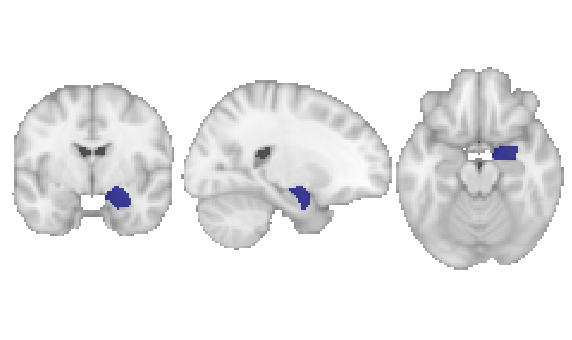

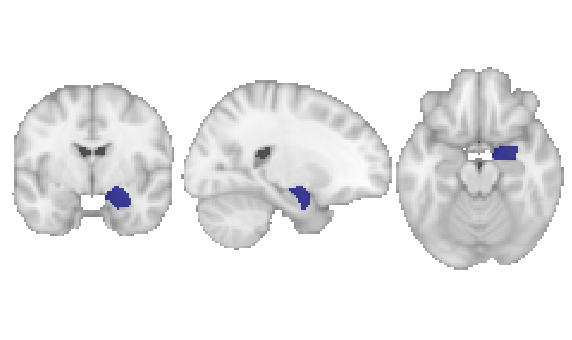

In [7]:
fig, ax = plt.subplots(figsize=(10, 6))
plotting.plot_roi(amygdala_roi, axes=ax, figure=fig, annotate=False, draw_cross=False)
glue("figure_roi_to_decode", fig, display=False)

```{glue:figure} figure_roi_to_decode
:name: figure_roi_to_decode
:align: center

The amygdala region of interest mask that will be used for discrete decoding.
```

One method which relies on correlations, much like the continuous correlation decoder, is the **ROI association** decoding method ({py:class}`nimare.decode.discete.ROIAssociationDecoder`), originally implemented in the Neurosynth Python library.
In this method, each study with coordinates in the dataset is convolved with a kernel transformer to produce a modeled activation map.
The resulting modeled activation maps are then masked with a region of interest (i.e., the target of the decoding), and the values are averaged within the ROI.
These averaged modeled activation values are then correlated with the term weights for all labels in the dataset.
This decoding method produces a single correlation coefficient for each of the dataset's labels.

In [8]:
assoc_decoder = decode.discrete.ROIAssociationDecoder(
    amygdala_roi,
    u=0.05,
    correction="fdr_bh",
    features=target_features,
)
assoc_decoder.fit(neurosynth_dset_first500)
assoc_df = assoc_decoder.transform()

In [9]:
assoc_df = assoc_df.reindex(assoc_df["r"].abs().sort_values(ascending=False).index)
assoc_df = assoc_df.iloc[:10]
glue("table_assoc", assoc_df)

,r
feature,
terms_abstract_tfidf__responses,0.139758
terms_abstract_tfidf__parietal,-0.135737
terms_abstract_tfidf__group,0.132898
terms_abstract_tfidf__medial,0.127090
terms_abstract_tfidf__functional magnetic,0.113273
terms_abstract_tfidf__superior,-0.110504
terms_abstract_tfidf__gyrus,-0.109145
terms_abstract_tfidf__studied,0.105478
terms_abstract_tfidf__frontal,-0.103911


```{glue:figure} table_assoc
:name: "tbl:table_assoc"
:align: center

The top ten terms, sorted by absolute correlation coefficient, from the ROI association decoding method.
```

In [10]:
# Here we delete the recent variables for the sake of reducing memory usage
del assoc_decoder, assoc_df

A more theoretically driven approach to ROI decoding is to use **chi-square-based** methods.
The two methods which use chi-squared tests are the BrainMap decoding method and an adaptation of Neurosynth’s meta-analysis method.

In both chi-square-based methods, studies are first selected from a coordinate-based database according to some criterion.
For example, if decoding a region of interest, users might select studies reporting at least one coordinate within 5 mm of the ROI.
Metadata (such as ontological labels) for this subset of studies are then compared to those of the remaining, unselected portion of the database in a confusion matrix.
For each label in the ontology, studies are divided into four groups: selected and label-positive (SS+L+), selected and label-negative (SS+L-), unselected and label-positive (SS-L+), and unselected and label-negative (SS-L-).
Each method then compares these groups in order to evaluate both consistency and specificity of the relationship between the selection criteria and each label, which are evaluated in terms of both statistical significance and effect size.

### BrainMap method

The BrainMap discrete decoding method, implemented in {py:class}`nimare.decode.discrete.BrainMapDecoder`, compares the distributions of studies with each label within the sample against those in a larger database while accounting for the number of foci from each study.
Broadly speaking, this method assumes that the selection criterion is associated with one peak per study, which means that it is likely only appropriate for selection criteria based around foci, such as regions of interest.
One common analysis, meta-analytic clustering, involves dividing studies within a database into meta-analytic groupings based on the spatial similarity of their modeled activation maps (i.e., study-wise pseudo-statistical maps produced by convolving coordinates with a kernel).
The resulting sets of studies are often functionally decoded in order to build a functional profile associated with each meta-analytic grouping.
While these groupings are defined as subsets of the database, they are not selected based on the location of an individual peak, and so weighting based on the number of foci would be inappropriate.

This decoding method produces four outputs for each label.
First, the distribution of studies in the sample with the label are compared to the distributions of other labels within the sample.
This consistency analysis produces both a measure of statistical significance (i.e., a p-value) and a measure of effect size (i.e., the likelihood of being selected given the presence of the label).
Next, the studies in the sample are compared to the studies in the rest of the database.
This specificity analysis produces a p-value and an effect size measure of the posterior probability of having the label given selection into the sample.
A detailed algorithm description is presented in **Appendix I**.

In [11]:
brainmap_decoder = decode.discrete.BrainMapDecoder(
    frequency_threshold=0.001,
    u=0.05,
    correction="fdr_bh",
    features=target_features,
)
brainmap_decoder.fit(neurosynth_dset_first500)
brainmap_df = brainmap_decoder.transform(amygdala_ids)

In [12]:
brainmap_df = brainmap_df.reindex(
    brainmap_df["probReverse"].abs().sort_values(ascending=False).index
)
brainmap_df = brainmap_df.iloc[:10]
glue("table_brainmap", brainmap_df)

,pForward,zForward,likelihoodForward,pReverse,zReverse,probReverse
Term,,,,,,
terms_abstract_tfidf__magnetic,0.742999,0.327884,1.304299,1.000000,0.000000,0.044836
terms_abstract_tfidf__magnetic resonance,0.742999,0.327884,1.259014,1.000000,0.000000,0.041626
terms_abstract_tfidf__resonance,0.742999,0.327884,1.253833,1.000000,0.000000,0.041605
terms_abstract_tfidf__functional magnetic,0.742999,0.327884,1.306109,1.000000,0.000000,0.041469
terms_abstract_tfidf__stimuli,0.312245,1.010524,2.151069,1.000000,0.000000,0.032607
terms_abstract_tfidf__response,0.399040,0.843338,1.776514,1.000000,0.000000,0.029686
terms_abstract_tfidf__using,1.000000,0.000000,1.163230,1.000000,0.000000,0.028324
terms_abstract_tfidf__human,0.545851,0.603989,1.773799,1.000000,0.000000,0.023501
terms_abstract_tfidf__primary,0.312245,1.010524,2.579048,1.000000,0.000000,0.021241


```{glue:figure} table_brainmap
:name: "tbl:table_brainmap"
:align: center

The top ten terms, sorted by reverse-inference posterior probability, from the BrainMap chi-squared decoding method.
```

In [13]:
# Here we delete the recent variables for the sake of reducing memory usage
del brainmap_decoder, brainmap_df

### Neurosynth method

The implementation of the MKDA Chi-squared meta-analysis method used by Neurosynth is quite similar to BrainMap’s method for decoding, if applied to annotations instead of modeled activation values.
This method, implemented in {py:class}`nimare.decode.discrete.NeurosynthDecoder`, compares the distributions of studies with each label within the sample against those in a larger database, but, unlike the BrainMap method, does not take foci into account.
For this reason, the Neurosynth method would likely be more appropriate for selection criteria not based on regions of interest (e.g., for characterizing meta-analytic groupings from a meta-analytic clustering analysis).
However, the Neurosynth method requires user-provided information that BrainMap does not.
Namely, in order to estimate probabilities for the consistency and specificity analyses with Bayes’ Theorem, the Neurosynth method requires a prior probability of a given label.
Typically, a value of 0.5 is used (i.e., the estimated probability that an individual is undergoing a given mental process described by a label, barring any evidence from neuroimaging data, is predicted to be 50%).
This is, admittedly, a poor prediction, which means that probabilities estimated based on this prior are not likely to be accurate, though they may still serve as useful estimates of effect size for the analysis.

Like the BrainMap method, this method produces four outputs for each label.
For the consistency analysis, this method produces both a p-value and a conditional probability of selection given the presence of the label and the prior probability of having the label.
For the specificity analysis, the Neurosynth method produces both a p-value and a posterior probability of presence of the label given selection and the prior probability of having the label.
A detailed algorithm description is presented in **Appendix II**.

In [14]:
neurosynth_decoder = decode.discrete.NeurosynthDecoder(
    frequency_threshold=0.001,
    u=0.05,
    correction="fdr_bh",
    features=target_features,
)
neurosynth_decoder.fit(neurosynth_dset_first500)
neurosynth_df = neurosynth_decoder.transform(amygdala_ids)

In [15]:
neurosynth_df = neurosynth_df.reindex(
    neurosynth_df["probReverse"].abs().sort_values(ascending=False).index
)
neurosynth_df = neurosynth_df.iloc[:10]
glue("table_neurosynth", neurosynth_df)

,pForward,zForward,probForward,pReverse,zReverse,probReverse
Term,,,,,,
terms_abstract_tfidf__cortices,1.903210e-01,1.309630,0.078536,0.125974,1.530173,0.744136
terms_abstract_tfidf__response,5.445621e-03,2.779419,0.062302,0.314800,1.005202,0.687898
terms_abstract_tfidf__stimuli,2.419735e-02,2.253981,0.063414,0.314800,1.005202,0.682923
terms_abstract_tfidf__time,4.273143e-01,0.793796,0.069020,0.426405,0.795358,0.676136
terms_abstract_tfidf__magnetic,5.085880e-10,6.216432,0.049496,0.439868,0.772416,0.666446
terms_abstract_tfidf__functional magnetic,3.188012e-09,5.921612,0.050929,0.439231,0.773493,0.664353
terms_abstract_tfidf__role,4.273143e-01,0.793796,0.066369,0.469744,0.722895,0.659193
terms_abstract_tfidf__lateral,4.273143e-01,0.793796,0.065410,0.519320,0.644395,0.652542
terms_abstract_tfidf__primary,6.143170e-01,0.503921,0.066680,0.539288,0.613890,0.652042


```{glue:figure} table_neurosynth
:name: "tbl:table_neurosynth"
:align: center

The top ten terms, sorted by reverse-inference posterior probability, from the Neurosynth chi-squared decoding method.
```

In [16]:
# Here we delete the recent variables for the sake of reducing memory usage
del neurosynth_decoder, neurosynth_df

In both methods, the database acts as an estimate of the underlying distribution of labels in the real world, such that the probability of having a peak in an ROI given the presence of the label might be interpreted as the probability of a brain activating a specific brain region given that the individual is experiencing a given mental state.
This is a very poor interpretation, given that any database of neuroimaging results will be skewed more toward the interests of the field than the distribution of mental states or processes experienced by humans, which is why decoding must be interpreted with extreme caution.
It is important not to place too much emphasis on the results of functional decoding analyses, although they are very useful in that they can provide a quantitative estimate behind the kinds of interpretations generally included in discussion sections that are normally only backed by informal literature searches or prior knowledge.

The meta-analytic functional decoding methods in NiMARE provide a very rudimentary approach for open-ended decoding (i.e., decoding across a very large range of mental states) that can be used with resources like NeuroVault.
However, standard classification methods have also been applied to datasets from NeuroVault (e.g., {cite:t}`Varoquaux2018-lo`), although these methods do not fall under NiMARE's scope.